#  Train a model with 4 observables and 2 external parameters
---
_This notebook reproduces the results of Section 5 from the paper: https://arxiv.org/abs/2108.11481_

Paper authors: S. Menary [sbmenary@gmail.com] and D. Price [darren.price@cern.ch]

Notebook author: S. Menary [sbmenary@gmail.com]

---

The aim of this notebook is to train a model which describes the electroweak production of a Z boson in association with 2 jets. We aim to describe how 4 observables are distributed, and capture how this 4D distribution is deformed upon variations of two external parameters.

Such a model could be used to perform parameter estimation over the space of the external parameters, or act as a stochastic generator.


## 1. Configuration

- Import python libraries
- Import local packages
- Configure global constants which steer the notebook
- Configure constants associated with data projection and neural network architecture

In [1]:
#========================#
#==  Import libraries  ==#
#========================#

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import cm, colors, pyplot as plt, lines, ticker as tck
from   matplotlib.colors import ListedColormap, LinearSegmentedColormap

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
top_dir = "/".join(os.getcwd().split("/")[:-1])
print(f"-  assuming top-level directory is {top_dir}")
sys.path.append(top_dir)
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel
from backends.plot             import histo_to_line, get_ratio_1D, get_ratio_2D, safe_divide
from backends.stats            import project_axes_onto_latent, project_axes_from_latent
from backends.utils            import make_sure_dir_exists_for_filename

from backends import density_model, VBFZ_analysis as VBFZ


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends
-  assuming top-level directory is /Users/Ste/PostDoc/git-with-DP/expressive_gaussian_mixture_models


In [2]:
#================================================#
#==  Configure steering commands for notebook  ==#
#================================================#

load_GMM                  = True
save_GMM                  = False

load_projection_functions = True
save_projection_functions = False

load_plottable_datapoints = False
save_plottable_datapoints = False


Register input $c_{\rm HWB}$ and ${\tilde c}_{\rm W}$ values, and a function which locates their filenames

In [3]:
#========================#
#==  Configure inputs  ==#
#========================#

cHWB_vals  = [-4.0, -2.0, 0.0, 2.0, 4.0]
cWtil_vals = [-0.4, -0.2, 0.0, 0.2, 0.4]

def get_input_fname (cHWB, cWtil) :
    cHWB_str  = f"{cHWB :.1f}".replace("-","m").replace(".","p")
    cWtil_str = f"{cWtil:.1f}".replace("-","m").replace(".","p")
    if (cHWB == 0) and (cWtil == 0) :
        return "../Data/SM_EWK_1M_rivet_output.pickle"
    if (cHWB == 0) :
        return f"../Data/cWtil_{cWtil_str}_full_400k_rivet_output.pickle"
    return f"../Data/cHWB_{cHWB_str}_cWtil_{cWtil_str}_full_200k_rivet_output.dat"


In [4]:
#================================#
#==  Configure neural network  ==#
#================================#

N_G                       = 30
max_epochs                = 200
batch_size                = 5000
early_stopping_patience   = 15
early_stopping_min_delta  = 1e-10
validation_split          = -1

scale_mu    = 1./8.
scale_f     = 1./8.
scale_sigma = 1./8.
f_sigma     = 1./4.
A1          = 50
A2          = 0
B1          = 50
B2          = 20
C_float     = 2
D2          = 3

learning_rate              = 0.001
learning_rate_evo_factor   = 0.5    
learning_rate_evo_patience = 3
optimiser                  = "adam"

model_dir = ".EWK_density_model_paper_2D"


In [5]:
#==============================================#
#==  Configure projection onto latent space  ==#
#==============================================#

proj_num_points                   = 200
proj_func_form                    = "step"
proj_alpha, proj_beta, proj_gamma = 4, 3, 1

proj_funcs_fname = "../Data/.proj_funcs_EWK_4obs.pickle"


In [6]:
#=======================#
#==  Configure plots  ==#
#=======================#

num_gen_evts_small = int(1e4)   # Number of events to sample from density model (ratio plots)
num_gen_evts_big   = int(1e5)   # Number of events to sample from density model (absolute dist)
num_gen_proc = 1                # Number of parallel processes to use for sampling (1 required for notebooks)

log_observables    = "pT_j1", "pT_j2", "pT_jj", "pT_ll", "m_jj", "rap_jj"
log_axis_functions = (lambda x : x**(1./3.), lambda x : x*x*x)

VBFZ.obs_ticks ["m_jj"     ] = [300, 1000, 2500, 4000]
VBFZ.obs_ticks ["rap_jj"   ] = [.1, .8, 3.]
VBFZ.obs_ticks ["pT_jj"    ] = [5 , 50, 200, 650]
VBFZ.obs_ticks ["pT_j1"    ] = [80, 300, 700]
VBFZ.obs_ticks ["pT_j2"    ] = [70, 300, 700]
VBFZ.obs_ticks ["pT_ll"    ] = [5 , 50, 200, 700]
VBFZ.obs_ticks ["Dphi_j_j" ] = [-np.pi, -np.pi/2., 0, np.pi/2., np.pi]

VBFZ.obs_ticklabels ["m_jj"     ] = [".3" , "1"  , "2.5", "4"]
VBFZ.obs_ticklabels ["rap_jj"   ] = ["0.1", "0.8", "3"]
VBFZ.obs_ticklabels ["pT_jj"    ] = ["5"  , "50" , "200", "650"]
VBFZ.obs_ticklabels ["pT_j1"    ] = ["80" , "200", "700"]
VBFZ.obs_ticklabels ["pT_j2"    ] = ["70" , "300", "700"]
VBFZ.obs_ticklabels ["pT_ll"    ] = ["5"  , "50" , "200", "700"]
VBFZ.obs_ticklabels ["Dphi_j_j" ] = [r"$-\pi$", r"$-\frac{\pi}{2}$", "0", r"$\frac{\pi}{2}$", r"$\pi$"  ]

custom_colormap_list = ListedColormap(["darkblue", "royalblue", "lightsteelblue", "springgreen", "lawngreen", "lightsalmon", "crimson", "darkred"], name='PullsList')
                      

In [7]:
#========================================================#
#==  Configure backends with the selected observables  ==#
#========================================================#
#
#  Configure observable choices within VBFZ backend
#
remove_observables = ["pT_jj", "N_jets", "N_gap_jets", "m_ll", "Dy_j_j", "rap_jj", "rap_ll", "pT_j2"]
VBFZ.configure(remove_observables, reverse=True)
num_observables    = VBFZ.num_observables
print(f"Configured with {num_observables} observables: " + ", ".join(VBFZ.observables))
#
#  Retrieve ordered list of constants for data projection (must be done after the step above)
#
proj_linear_fraction_data_space   = [0 if obs in VBFZ.int_observables else VBFZ.get_obs_proj_linear_fraction_data_space  (obs) for obs in VBFZ.observables]
proj_linear_fraction_latent_space = [0 if obs in VBFZ.int_observables else VBFZ.get_obs_proj_linear_fraction_latent_space(obs) for obs in VBFZ.observables]


Configured with 4 observables: pT_ll, pT_j1, m_jj, Dphi_j_j


##  2. Load input data

We will load the MG5 data from the filenames provided. Use the VBFZ backend to handle all of the filtering of events so that they all fall within our fiducial region.

In [8]:
#  Load and format the data
#

data_tables = {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        input_fname = get_input_fname (cHWB, cWtil)
        data_tables [(cHWB, cWtil)] = VBFZ.load_table(input_fname)
    

Loading events from file ../Data/cHWB_m4p0_cWtil_m0p4_full_200k_rivet_output.dat
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 130332 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 130259 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 130259 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 128561 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 126644 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 126644 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 126644 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 126644 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 126054 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 125820 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 125820 events survived
 --

 -- 125509 events survived
 -- removing observable pT_jj
 -- removing observable N_jets
 -- removing observable N_gap_jets
 -- removing observable m_ll
 -- removing observable Dy_j_j
 -- removing observable rap_jj
 -- removing observable rap_ll
 -- removing observable pT_j2
 -- removing observable theta_ll
 -- removing observable theta_jj
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | pT_ll    | <class 'float'> |
    | 1      | pT_j1    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dphi_j_j | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 0.7219         |
    +-------------------------+

* Number of events       : 125509
* Cross section p

 -- 131742 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 131738 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 131738 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130007 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128133 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128133 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128133 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128133 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 127622 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 127407 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 127407 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 127407 events survived
 -- filtering observable N_jets between 2 and 5
 -- 127407 e

 -- 264467 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 264437 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 264437 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 261020 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 257387 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 257387 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 257387 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 257387 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 256425 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 255991 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 255991 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 255991 events survived
 -- filtering observable N_jets between 2 and 5
 -- 255991 e

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132875 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132825 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132825 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 131078 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129267 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129267 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129267 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129267 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 128729 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 128525 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128525 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132810 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132776 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132776 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 131051 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129188 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129188 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129188 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129188 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 128734 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 128504 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128504 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- removing observable theta_ll
 -- removing observable theta_jj
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | pT_ll    | <class 'float'> |
    | 1      | pT_j1    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dphi_j_j | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.7880         |
    +-------------------------+

* Number of events       : 128583
* Cross section per event: 0.25358
* Total cross section    : 0.45339959044543127 +/- 0.0012658316478216297 pb
Loading events from file ../Data/cHWB_4p0_cWtil_0p2_full_200k_rivet_output.dat
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132702 event

## 3. Project the data onto the latent space

- If projection functions already saved to file, load these, otherwise evaluate them at the SM
- Project data, and add it to a dictionary
- Also produce a dictionary of normalised weights which will be used to train

In [9]:
#======================================#
#==  Project data onto latent space  ==#
#======================================#
#
#  Create a container which specifies the projection config for every observable
#
axis_configs = [[VBFZ.observable_limits[obs][0], 
                 VBFZ.observable_limits[obs][1], 
                 proj_num_points,  
                 proj_linear_fraction_data_space[idx], 
                 proj_linear_fraction_latent_space[idx]] for idx, obs in enumerate(VBFZ.observables)]
#
#  If projection functions were already calculated in a previous run, we will load them to speed things up
#  Otherwise we calculate them at a value of cWtil=0 and save them if requested
#
if (load_projection_functions) and (type(proj_funcs_fname) is str) and (os.path.isfile(proj_funcs_fname)) :
    print(f"Loading projection functions from file {proj_funcs_fname}")
    proj_funcs = pickle.load(open(proj_funcs_fname, "rb"))
else :
    print(f"Calculating projection functions at the origin")
    data = data_tables[(0.,0.)]
    observables_origin, weights_origin = data.get_observables_and_weights()
    _, proj_funcs = project_axes_onto_latent(observables_origin, data.types, weights=weights_origin, axis_configs=axis_configs, proj_funcs=None, 
                                             func_form=proj_func_form, alpha=proj_alpha, beta=proj_beta, gamma=proj_gamma)
#
#  Project data onto latent space, and store records of the initial data and event weights
#  
print(f"Projecting data onto latent space...")
observable_data, data_weights, latent_data = {}, {}, {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        key  = (cHWB, cWtil)
        data = data_tables[key]
        observable_data[key], data_weights[key] = data.get_observables_and_weights()
        latent_data[key], _ = project_axes_onto_latent(observable_data[key], data.types, weights=data_weights[key], axis_configs=axis_configs, proj_funcs=proj_funcs)
print("...complete")
#
#  Create container of weights which sum to 1 for every (cHWB, cWtil) pair. This will be used to train
#      the neural networks in a way which does not give higher weight to any particular (cHWB, cWtil)    
#
weights_to_fit = {k:i/np.sum(i) for k,i in data_weights.items()}
#
#  Save projection functions to file if requested
#
if (save_projection_functions) and (type(proj_funcs_fname) is str) :
    print(f"Saving projection functions to file {proj_funcs_fname}")
    make_sure_dir_exists_for_filename(proj_funcs_fname)
    pickle.dump(proj_funcs, open(proj_funcs_fname, "wb"))
    

Loading projection functions from file ../Data/.proj_funcs_EWK_4obs.pickle
Projecting data onto latent space...
...complete


##  4. Obtain the density model

- Load the density model if so configured
- Otherwise build a new one and fit it to the MG5 data

In [10]:
#==================================
#===   LOAD / BUILD&FIT MODEL   ===
#==================================


#  Load model if requested, otherwise build
#
if load_GMM and type(model_dir) is str and os.path.isdir(model_dir) :
    print(f"Loading density model from directory {model_dir}")
    global_density_model = DensityModel.from_dir(model_dir)
else :
    #
    #   Figure out the limits of the observables on the latent space
    #
    obs_lims = []
    for obs_idx in range(VBFZ.num_observables) :     
        min_dp, max_dp     = np.min([np.min(data[:,obs_idx]) for c,data in latent_data.items()]), np.max([np.max(data[:,obs_idx]) for c,data in latent_data.items()])
        range_dp_per_gauss = (max_dp - min_dp) / N_G
        obs_lims.append([min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss]) 
    #
    #   Create density model  
    #
    global_density_model = DensityModel(name        = "VBFZ_2D_density_model", 
                                 num_gaussians      = N_G                    , 
                                 num_conditions     = 2                      , 
                                 num_observables    = VBFZ.num_observables   ,
                                 observables_limits = obs_lims               ,
                                 verbose            = True                   , 
                                 gauss_width_factor = f_sigma                ,
                                 gauss_mean_scale   = scale_mu               ,
                                 gauss_frac_scale   = scale_f                ,
                                 gauss_sigma_scale  = scale_sigma            ,
                                 optimiser          = optimiser              ,
                                 learning_rate      = learning_rate          ,
                                 A1                 = A1                     ,
                                 A2                 = A2                     ,
                                 B1                 = B1                     ,
                                 B2                 = B2                     ,
                                 C_float            = C_float                ,
                                 D2                 = D2                     )
    #
    #   Make sure initial state has no NaN/Inf loss
    #
    global_density_model.ensure_valid_over_dataset (latent_data, weights_to_fit)
    #
    #  Fit model if not loaded
    #
    global_density_model.fit(latent_data                                             ,
                             weights_to_fit                                          ,
                             max_epochs_per_observable  = max_epochs                 ,
                             early_stopping_patience    = early_stopping_patience    ,
                             early_stopping_min_delta   = early_stopping_min_delta   ,
                             validation_split           = validation_split           ,
                             batch_size_per_observable  = batch_size                 ,
                             learning_rate_evo_factor   = learning_rate_evo_factor   ,
                             learning_rate_evo_patience = learning_rate_evo_patience )


Loading density model from directory .EWK_density_model_paper_2D


In [11]:
#======================
#===   SAVE MODEL   ===
#======================
#
#  Save model to file if requested

if save_GMM and type(model_dir) == str :
    print(f"Saving density model to directory {model_dir}")
    global_density_model.save_to_dir(model_dir)
    

##  5. Sample density model

As we did for the 0D model in the previous notebook, we will now sample the density model to obtain datapoints which we can compare with the MG5 data. We will generate two datasets assuming the SM hypothesis:
- a large dataset contains events which can be compared with MG5 data, to show that we have correctly learned the absolute distribution at the SM.
- a small dataset contains events which can be reweighted to difference hypothesis c = (cHWB, cWtil) using factors of w = p_c(x) / p_SM(x), where p_c and p_SM are evaluated using the density model. This will be used to study the ratio of the c hypothesis to the SM, where we aim to see that this ratio matches that from MG5 events. By using the same events and reweighting them, both sides of the ratio have highly correlated fluctuations, and so the ratio itself has much smaller variance than if events were sampled independently at the c and SM hypotheses.

If these events have been generated before, we will just load them instead. This saves time performing the sampling and reweighting.

In [12]:
#==========================================================
#===   Load sampled datapoints from file if requested   ===
#==========================================================
#
datapoints_fname = f"{model_dir}/plot_2D_datapoints.pickle"
if load_plottable_datapoints :
    print(f"Loading plottable datapoints from file {datapoints_fname}")
    loaded = pickle.load(open(datapoints_fname, "rb"))
    fake_latent_datapoints_SM     = loaded["fake_latent_datapoints_SM"    ]
    fake_datapoints_SM            = loaded["fake_datapoints_SM"           ]
    fake_latent_datapoints_SM_big = loaded["fake_latent_datapoints_SM_big"]
    fake_datapoints_SM_big        = loaded["fake_datapoints_SM_big"       ]
    fake_datapoint_SM_likelihood  = loaded["fake_datapoint_SM_likelihood" ]
    fake_datapoint_weights        = loaded["fake_datapoint_weights"       ]
    

Loading plottable datapoints from file .EWK_density_model_paper_2D/plot_2D_datapoints.pickle


In [13]:
#================================
#===   Sample density model   ===
#================================
#
#  Generate a small number of datapoints at (0,0), to be used to study ratio of distributions
#
if not load_plottable_datapoints :
    print(f"Generating {num_gen_evts_small} fake datapoints for [cHWB, cWtil] = [0, 0]")
    start = time.time()
    fake_latent_datapoints_SM = global_density_model.sample(num_gen_evts_small, [0, 0])
    end = time.time()
    print(f"{num_gen_evts_small} datapoints generated at (0, 0) in {int(end-start):.0f}s")
#
#  Invert generated data
#
if not load_plottable_datapoints :
    print("Inverting fake datapoints for  (0, 0)")
    start = time.time()
    fake_datapoints_SM = project_axes_from_latent(fake_latent_datapoints_SM, proj_funcs)
    end = time.time()
    print(f"{num_gen_evts_small} datapoints inverted at (0, 0) in {int(end-start):.0f}s")


In [14]:
#================================
#===   Sample density model   ===
#================================
#
#  Generate a large number of datapoints at (0,0), to be used to study absolute distributions
#
if not load_plottable_datapoints :
    print(f"Generating {num_gen_evts_big} fake datapoints for [cHWB, cWtil] = [0, 0]")
    start = time.time()
    fake_latent_datapoints_SM_big = global_density_model.sample(num_gen_evts_big, [0, 0])
    end = time.time()
    print(f"{num_gen_evts_big} datapoints generated at cWtil=0 in {int(end-start):.0f}s")
#
#  Invert generated data
#
if not load_plottable_datapoints :
    print("Inverting fake datapoints for  (0, 0)")
    start = time.time()
    fake_datapoints_SM_big = project_axes_from_latent(fake_latent_datapoints_SM_big, proj_funcs)
    end = time.time()
    print(f"{num_gen_evts_big} datapoints inverted at (0, 0) in {int(end-start):.0f}s")


In [15]:
#====================================================================
#===   Reweight SM datapoints to every point in parameter space   ===
#====================================================================
#
#  First evaluate p_SM(x)
#
if not load_plottable_datapoints :
    fake_datapoint_SM_likelihood = global_density_model.evaluate([0, 0], fake_latent_datapoints_SM)
#
#  Now evaluate weights w(x) = p_c(x) / p_SM(x) for every generated value of c
#
if not load_plottable_datapoints :
    fake_datapoint_weights = {}
    for cHWB in cHWB_vals :
        for cWtil in cWtil_vals :
            start = time.time()
            fake_datapoint_weights[(cHWB, cWtil)] = global_density_model.evaluate([cHWB, cWtil], fake_latent_datapoints_SM) / fake_datapoint_SM_likelihood
            end = time.time()
            print(f"{len(fake_latent_datapoints_SM)} datapoints evaluated at {cHWB, cWtil} in {(end-start):.2f}s")


In [16]:
#===============================================================================
#===   Save generate datapoints to file so we can reproduce plots later on   ===
#===============================================================================
#
if save_plottable_datapoints :
    print(f"Saving plottable datapoints to file {datapoints_fname}")
    to_save = {}
    to_save["fake_latent_datapoints_SM"    ] = fake_latent_datapoints_SM
    to_save["fake_datapoints_SM"           ] = fake_datapoints_SM
    to_save["fake_latent_datapoints_SM_big"] = fake_latent_datapoints_SM_big
    to_save["fake_datapoints_SM_big"       ] = fake_datapoints_SM_big
    to_save["fake_datapoint_SM_likelihood" ] = fake_datapoint_SM_likelihood
    to_save["fake_datapoint_weights"       ] = fake_datapoint_weights
    pickle.dump(to_save, open(datapoints_fname, "wb")) 
    

##  6.  Prepare for plotting

The following cells define methods which will be used to create the final plots later on.

In [17]:
#==========================================#
#==  Some methods to help with plotting  ==#
#==========================================#
#
#  Method plots 1D ratio observable on axis ax
#
def plot_1D_ratio_on_axis (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, linecolor="k", linewidth=1., fillcolor="grey", fillalpha=0.4, normed=True, ebar=False, offset=-1., log=False) :
    data_x, data_z, data_ez = get_1D_ratio_lines(observable, data_num, data_den, weights_num=weights_num, weights_den=weights_den, keys=keys, cuts=cuts, lims=lims, bins=bins, normed=normed)
    ax.plot(data_x, np.log(data_z+offset) if log else data_z+offset, color=linecolor, label=label, linewidth=linewidth)
    if ebar : 
        if log :
            ax.fill_between(data_x, np.log(data_z+data_ez+offset), np.log(data_z-data_ez+offset), alpha=fillalpha, color=fillcolor)
        else :
            ax.fill_between(data_x, data_z+data_ez+offset, data_z-data_ez+offset, alpha=fillalpha, color=fillcolor)
        
    return data_x, data_z+offset, data_ez
#
#  Method plots 1D double ratio observable on axis ax
#
def plot_1D_double_ratio_on_axis (ax, observable, data_num_num, data_num_den, data_den_num, data_den_den, weights_num_num=None, weights_num_den=None, weights_den_num=None, weights_den_den=None, allow_den_errs=True, keys=None, cuts=[], save="", lims=True, bins=20, label=None, linecolor="k", linewidth=1., fillcolor="grey", fillalpha=0.4, normed=True, ebar=False, offset=-1., log=False) :
    data_num_x, data_num_z, data_num_ez = get_1D_ratio_lines(observable, data_num_num, data_num_den, weights_num=weights_num_num, weights_den=weights_num_den, keys=keys, cuts=cuts, lims=lims, bins=bins, normed=normed)
    data_den_x, data_den_z, data_den_ez = get_1D_ratio_lines(observable, data_den_num, data_den_den, weights_num=weights_den_num, weights_den=weights_den_den, keys=keys, cuts=cuts, lims=lims, bins=bins, normed=normed)
    for x_num, x_den in zip(data_num_x,data_den_x) : assert x_num == x_den, f"{x_num} != {x_den}"
    data_x  = data_num_x
    data_z  = safe_divide(data_num_z, data_den_z)
    if allow_den_errs : data_ez = data_z * np.sqrt(safe_divide(data_num_ez,data_num_z)**2 + safe_divide(data_den_ez,data_den_z)**2)
    else              : data_ez = data_z * safe_divide(data_num_ez,data_num_z)
    ax.plot(data_x, np.log(data_z+offset) if log else data_z+offset, color=linecolor, label=label, linewidth=linewidth)
    if ebar : 
        if log :
            ax.fill_between(data_x, np.log(data_z+data_ez+offset), np.log(data_z-data_ez+offset), alpha=fillalpha, color=fillcolor)
        else :
            ax.fill_between(data_x, data_z+data_ez+offset, data_z-data_ez+offset, alpha=fillalpha, color=fillcolor)
        
    return data_x, data_z+offset, data_ez
#
#  Method computes the 1D ratio lines with errorbars
#
def get_1D_ratio_lines (observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], lims=True, bins=20, normed=True) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = VBFZ.observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if type(bins) not in [list, np.ndarray] :
        if observable in VBFZ.int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
        else                                  : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z) 
    return data_x, data_z, data_ez
#
#  Method returns the 1D binning for the provided data
#
def get_adaptive_bins_v1(data, weights=None, limits=None, obs=None, max_err=-1) :
    if type(limits ) == type(None) :
        if obs : limits = VBFZ.observable_limits[obs]
        else   : limits = [np.min(data), np.max(data)]
    if type(weights) == type(None) : weights   = np.ones(shape=(len(data),))
    if type(obs    ) == type(None) : increment = (limits[1] - limits[0]) / 100
    elif obs == "Dphi_j_j" : increment = np.pi / 16
    elif obs == "pT_j1" : 
        increment = 10
        if max_err < 0 : max_err = 0.015
    elif "pT" in obs : increment = 10
    elif "m_" in obs       : 
        increment = 25
        if max_err < 0 : max_err   = 0.02
    else : increment = (limits[1] - limits[0]) / 100
    if max_err < 0 : max_err = 0.05
    lim_range = limits[1] - limits[0]
    bins      = [x for x in np.linspace(limits[0], limits[1], 1+int(lim_range/increment))]
    keep_merging = True
    while keep_merging :
        vals, _   = np.histogram(data, bins=bins)
        errs      = np.sqrt(vals)
        frac_errs = [x for x in safe_divide(errs, vals)]  # , rogue=0, rogue2=0
        curr_err  = np.max(frac_errs)
        if len(bins) == 2 :
            keep_merging = False
        elif 0 in frac_errs :
            idx = len(frac_errs) - frac_errs[::-1].index(0) - 1
            del bins[idx]
        elif curr_err < max_err :
            keep_merging = False
        else :
            idx = frac_errs.index(curr_err)
            if   idx == 0             : del bins[1]
            elif idx == len(bins) - 2 : del bins[-2]
            elif frac_errs[idx-1] > frac_errs[idx>1] : del bins[idx]
            else : del bins[idx+1]
    return bins
#
#  Method returns the 1D binning for the provided data
#
def get_adaptive_bins_v2(data, weights=None, obs=None, num_increments=100, max_err=0.05, is_latent=False) :
    if not is_latent :
        if (type(obs) != type(None)) and (obs == "N_gap_jets") : return np.array([-0.5, 0.5, 2.5])
        if (type(obs) != type(None)) and (obs == "N_jets")     : return np.array([1.5, 2.5, 5.5])
        if obs : limits = VBFZ.observable_limits[obs]
        else   : limits = [np.min(data), np.max(data)]
    elif (obs == "N_gap_jets") : return np.array([-0.5, 0.5, 2.5])
    elif (obs == "N_jets")     : return np.array([1.5, 2.5, 5.5]) - 2.
    else : limits = [-5, 5]
    if type(weights) == type(None) : weights   = np.ones(shape=(len(data),))
    bins = [x for x in np.linspace(limits[0], limits[1], 1+num_increments)]
    keep_merging = True
    while keep_merging :
        vals, _   = np.histogram(data, bins=bins)
        errs      = np.sqrt(vals)
        frac_errs = [x for x in safe_divide(errs, vals, rogue_den=np.inf, rogue_both=np.inf)]
        curr_err  = np.max(frac_errs)
        if len(bins) == 2 :
            keep_merging = False
        elif 0 in frac_errs :
            idx = len(frac_errs) - frac_errs[::-1].index(0) - 1
            del bins[idx]
        elif curr_err < max_err :
            keep_merging = False
        else :
            idx = frac_errs.index(curr_err)
            if   idx == 0             : del bins[1]
            elif idx == len(bins) - 2 : del bins[-2]
            elif frac_errs[idx-1] > frac_errs[idx>1] : del bins[idx]
            else : del bins[idx+1]
    return np.array(bins)
#
#  Method returns the tick positions for a given observable
#
def get_obs_ticks (obs, is_latent=False) :
    if is_latent :
        if obs not in VBFZ.int_observables : return np.array([-3, 0, 3])
        return VBFZ.get_obs_ticks(obs)
    return VBFZ.get_obs_ticks(obs)
#
#  Method returns the tick labels for a given observable
#
def get_obs_ticklabels (obs, is_latent=False) :
    if is_latent :
        if obs not in VBFZ.int_observables : return np.array(["-3", "0", "3"])
        return VBFZ.get_obs_ticklabels(obs)
    return VBFZ.get_obs_ticklabels(obs)
#
#  Method returns a list of all pairs of observables
#
def get_obs_for_2D_plot (observables) :
    obs_to_plot = []
    for obs_idx_x, obs_x in enumerate(observables) :
        if obs_idx_x == len(observables)-1 : continue
        for obs_idx_y, obs_y in enumerate(observables) :
            if obs_idx_y == 0         : continue
            if obs_idx_y <= obs_idx_x : continue
            obs_to_plot.append((obs_idx_x, obs_x, obs_idx_y, obs_y))
    return obs_to_plot

In [18]:
#==========================================#
#==  Some methods to help with plotting  ==#
#==========================================#
#
#  Method makes a plot of the 1D projections of the datapoints provided
#
def plot_1D_projections (datapoints_num, datapoints_den, weights_num=None, weights_den=None, savefig="", is_latent=False, num_bins=20, max_cols=6) :
    """plot the 1D projections of the datapoints provided"""
    
    observables      , num_observables = VBFZ.observables      , VBFZ.num_observables
    observable_limits, int_observables = VBFZ.observable_limits, VBFZ.int_observables
    #
    #  If no weights provided then assume uniform
    #
    if type(weights_num) == type(None) : weights_num = np.ones(shape=(datapoints_num.shape[0],))
    if type(weights_den) == type(None) : weights_den = np.ones(shape=(datapoints_den.shape[0],))
    #
    #  Calculate out plot dimensions and create figure
    #
    num_cols = np.min([max_cols, num_observables])
    num_rows = math.ceil(num_observables/num_cols)
    fig = plt.figure(figsize=(2*num_cols, 6*num_rows))
    #
    #  Loop over subplots
    #
    axes1, axes2 = [], []
    ymins, ymaxs = [], []
    for row_idx in range(num_rows) :
        for col_idx in range(num_cols) :
            obs_idx = num_cols*row_idx + col_idx
            if obs_idx >= num_observables : continue
            observable = observables[obs_idx]
            #
            #  Get axis co-ordinates
            #
            xlo, xwidth  = col_idx/num_cols, 1./num_cols
            ylo, yheight = 1. - (1+row_idx)/num_rows, 1./num_rows
            #
            #  Get values of distributions
            #
            #  get binning
            bins       = get_adaptive_bins_v2(datapoints_den[:,obs_idx], weights_den, obs=observable, num_increments=30, max_err=0.02, is_latent=is_latent)
            bin_widths = bins[1:] - bins[:-1]
            #  numerator histo values
            hvals_num, _ = np.histogram(datapoints_num[:,obs_idx], bins=bins, weights=weights_num            )
            herrs_num, _ = np.histogram(datapoints_num[:,obs_idx], bins=bins, weights=weights_num*weights_num)
            herrs_num    = np.sqrt(herrs_num)
            hvals_num, herrs_num = hvals_num/np.sum(weights_num)/bin_widths, herrs_num/np.sum(weights_num)/bin_widths
            norm_vals    = np.max(hvals_num)
            hvals_num, herrs_num = hvals_num / norm_vals, herrs_num / norm_vals
            #  denominator histo values
            hvals_den, _ = np.histogram(datapoints_den[:,obs_idx], bins=bins, weights=weights_den            )
            herrs_den, _ = np.histogram(datapoints_den[:,obs_idx], bins=bins, weights=weights_den*weights_den)
            herrs_den    = np.sqrt(herrs_den)
            hvals_den, herrs_den = hvals_den/np.sum(weights_den)/bin_widths, herrs_den/np.sum(weights_den)/bin_widths
            hvals_den, herrs_den = hvals_den / norm_vals, herrs_den / norm_vals
            #  histograms expressed as lines
            plot_x, plot_y_num, plot_ey_num = histo_to_line(bins, hvals_num, herrs_num)
            _     , plot_y_den, plot_ey_den = histo_to_line(bins, hvals_den, herrs_den)
            #
            #  Create absolute distribution plot (top panel of each observable)
            #
            ax1 = fig.add_axes([xlo, ylo+0.6*yheight, 0.95*xwidth, 0.38*yheight])
            ax1.plot(plot_x, plot_y_num, "-", color="k"      , linewidth=2)
            ax1.fill_between(plot_x, plot_y_num-plot_ey_num, plot_y_num+plot_ey_num, color="lightgrey", alpha=1)
            ax1.plot(plot_x, plot_y_den, "-", color="darkred", linewidth=2)
            ax1.fill_between(plot_x, plot_y_den-plot_ey_den, plot_y_den+plot_ey_den, color="red", alpha=0.2)
            ax1.set_yscale("log")
            #
            # Save ymin, ymax and top axis for this observable
            #
            ymin, ymax = np.min([plot_y_num-plot_ey_num, plot_y_den-plot_ey_den]), np.max([plot_y_num+plot_ey_num, plot_y_den+plot_ey_den])
            ymins.append(ymin)
            ymaxs.append(ymax)
            axes1.append(ax1)
            #
            #  Create ratio plot (bottom panel of each observable) and save it
            #
            plot_ey_diff = np.sqrt(plot_ey_num*plot_ey_num + plot_ey_den*plot_ey_den)
            ax2 = fig.add_axes([xlo, ylo+0.2*yheight, 0.95*xwidth, 0.38*yheight])
            ax2.axhline(0, c="darkred", linewidth=2)
            ax2.fill_between(plot_x, -safe_divide(plot_ey_den, plot_y_den), safe_divide(plot_ey_den, plot_y_den), color="red", alpha=0.2)
            ax2.plot(plot_x, safe_divide(plot_y_num-plot_y_den, plot_y_den), c="k", linewidth=2)
            ax2.fill_between(plot_x, safe_divide(plot_y_num-plot_ey_num-plot_y_den, plot_y_den), safe_divide(plot_y_num+plot_ey_num-plot_y_den, plot_y_den), color="lightgrey", alpha=0.5)
            axes2.append(ax2)
            #
            #  Set ylim and draw horizontal reference lines
            #
            ax2.set_ylim([-0.06, 0.06])
            for h in np.linspace(-0.05, 0.05, 11) :
                ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)
            #  
            #  Set x limits and scale
            #  
            ax1.set_xlim([bins[0], bins[-1]])
            ax2.set_xlim([bins[0], bins[-1]])
            if not is_latent :
                if observable in log_observables :
                    ax1.set_xscale("function", functions=log_axis_functions )
                    ax2.set_xscale("function", functions=log_axis_functions )
            #
            #  Set axis ticks
            #   
            if col_idx > 0 :
                ax1.get_yaxis().set_ticklabels([])
                ax2.get_yaxis().set_ticklabels([])
            ax1.set_xticks(get_obs_ticks(observable, is_latent=is_latent))
            ax2.set_xticks(get_obs_ticks(observable, is_latent=is_latent))
            ax1.get_xaxis().set_ticklabels([])
            ax2.get_xaxis().set_ticklabels(get_obs_ticklabels(observable, is_latent=is_latent))
            #   
            #  Set axis labels
            #   
            ax2.set_xlabel(VBFZ.get_obs_label(observable), fontsize=19, labelpad=20)
            if col_idx == 0 : 
                ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
                ax2.set_ylabel("Ratio to\nMG5", fontsize=19, labelpad=65, rotation=0, va="center")
                ax2.set_yticks     ([-0.04, -0.02, 0, 0.02, 0.04])
                ax2.set_yticklabels([r"$-4\%$", r"$-2\%$", r"$0$", r"$+2\%$", r"$+4\%$"])
            #  
            #  Set tick params
            #  
            ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
            ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    #
    #  Set consistent axis y lims
    #
    ymin, ymax = np.min([y for y in ymins if y > 0])/2., 2.*np.max(ymaxs)
    for ax in axes1 :
        ax.set_ylim([ymin, ymax])
    #
    #  Set y-axis ticks and legend
    #
    leg_proxy  = [lines.Line2D([], [], color='black' , linestyle='-', lw=2, alpha=1),
                  plt.Rectangle((0,0),1,1,fc="red",ec="darkred",lw=2,ls="-",alpha=0.2)]
    leg_labels = ["Samples from density model", "MG5 events"]
    axes1[0].legend(leg_proxy, leg_labels, loc=(0.75, 1.08), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)
    axes1[0].text(-0.35, 1.13, r"$(c_{HWB}, {\tilde c}_W) = (0,0)$",fontsize=14, transform=axes1[0].transAxes, ha="left", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0))
    #
    #  Save and show figure
    #
    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    else :
        plt.show()

In [19]:
#==========================================#
#==  Some methods to help with plotting  ==#
#==========================================#
#
#  Some global constants to place the ticks nicely
#
lin_ticks = {}
lin_ticks["pT_ll"    ] = [0, 300, 600]
lin_ticks["pT_j1"    ] = [40, 500, 1000]
lin_ticks["m_jj"     ] = [150, 2000, 4000]
lin_ticks["Dphi_j_j" ] = [-2*np.pi/3, 0, 2*np.pi/3]
#
#  ... and their respective labels
#
lin_ticklabels = {}
lin_ticklabels["pT_ll"   ] = ["0", "300", "600"]
lin_ticklabels["pT_j1"   ] = ["40", "500", "1000"]
lin_ticklabels["m_jj"    ] = [".15", "2", "4"]
lin_ticklabels["Dphi_j_j"] = [r"$-\frac{2\pi}{3}$", "0", r"$\frac{2\pi}{3}$"]
#
#  Method makes a plot of the 2D projections of the datapoints provided
#
def plot_2D_projections (datapoints, weights=None, label="", savefig="") :
    num_observables = VBFZ.num_observables
    
    #  If no weights provided then assume uniform
    if type(weights) == type(None) :
        weights = np.ones(shape=(datapoints.shape[0],))
    
    #  Get histo bins
    get_bins = {}
    for obs_idx_x, obs_x in enumerate(VBFZ.observables) :
        obs_lims_x = VBFZ.observable_limits[obs_x]
        num_bins_x = 20
        if obs_x in VBFZ.int_observables : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0]-0.5, obs_lims_x[1]+0.5, 1+(obs_lims_x[1]-obs_lims_x[0]))
        else                             : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0], obs_lims_x[1], num_bins_x+1)

    #  First figure out our colour axis limits
    #     whilst we're at it, save the list of indices to plot (to make sure all loops are over consistent sets)
    vmin = 1e30
    observables_for_x, observables_for_y = [], []
    for obs_idx_x, obs_x in enumerate(VBFZ.observables) :
        #  Don't plot observable -1 on x axis
        if obs_idx_x == num_observables-1 : continue
        observables_for_x.append(obs_idx_x)
        for obs_idx_y, obs_y in enumerate(VBFZ.observables) :
            #  Don't plot observable 0 or above diagonal on y axis
            if obs_idx_y == 0         : continue
            if obs_idx_y <= obs_idx_x : continue
            observables_for_y.append(obs_idx_y)
            #  Get histo limits
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            vals, _, _ = np.histogram2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights, bins=(bins_x, bins_y))
            vals = vals.flatten()
            vals_min, vals_max = np.nanmin([v for v in vals if v > 0]), np.nanmax([v for v in vals if v > 0])
            vmin = np.nanmin([vmin, vals_min/vals_max])

    #  Make plot
    fig = plt.figure(figsize=(8, 5))
    vmin = 1e-5

    is_first_x = True
    for obs_idx_x, obs_x in enumerate(VBFZ.observables) :

        #  Check whether we want to plot observable x
        if obs_idx_x not in observables_for_x : continue

        #  Get axis x coordinates
        xlo    = obs_idx_x / (num_observables-1)
        xwidth = 1.        / (num_observables-1)

        for obs_idx_y, obs_y in enumerate(VBFZ.observables) :

            #  Check whether we want to plot observable y
            if obs_idx_y not in observables_for_y : continue
            if obs_idx_y <= obs_idx_x : continue

            #  Get axis y coordinates
            ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)
            yheight = 1.                            / (num_observables-1)

            #  Create axis
            ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])

            #  Decide whether to draw axis labels
            if obs_idx_x != 0 : ax.get_yaxis().set_ticklabels([])
            else : 
                ax.set_ylabel(VBFZ.get_obs_label(obs_y), fontsize=19, labelpad=20)
            if obs_idx_y != num_observables-1 : ax.get_xaxis().set_ticklabels([])
            else : 
                ax.set_xlabel(VBFZ.get_obs_label(obs_x), fontsize=19, labelpad=20)
                
            #  Set axis ticks and labels
            if obs_x in lin_ticks : ax.get_xaxis().set_ticks(lin_ticks[obs_x])
            if obs_y in lin_ticks : ax.get_yaxis().set_ticks(lin_ticks[obs_y])
            if is_first_x     : ax.get_yaxis().set_ticklabels(lin_ticklabels[obs_y])
            else              : ax.get_yaxis().set_ticklabels([])
            if obs_idx_y == num_observables - 1 : ax.get_xaxis().set_ticklabels(lin_ticklabels[obs_x])
            else              : ax.get_xaxis().set_ticklabels([])
        
            #  Format tick params
            ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

            #  Draw histogram
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            _, _, _, patches = ax.hist2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights/vals_max, bins=(bins_x, bins_y),
                                      vmin=vmin, vmax=1, norm=colors.LogNorm())
            
            if (obs_idx_x==0) and (obs_idx_y==1) and len(label) > 0 :
                ax.text(0.3 + len(label)*0.06, 1.2, r"$(c_{HWB}, {\tilde c}_W) = (0,0)$",fontsize=19, transform=ax.transAxes, ha="left", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0))
                ax.text(0, 1.2, label, weight="bold", ha="left", va="bottom", transform=ax.transAxes, fontsize=19)
                            
        is_first_x = False
                

    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(patches, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])
    cbar   .set_label(r"$\frac{p(x)}{{\rm max}~p(x)}$", fontsize=25, labelpad=50, rotation=0, va="center")

    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    else :
        plt.show()

In [20]:
#==========================================#
#==  Some methods to help with plotting  ==#
#==========================================#
#
#  Method makes a plot ratios the 2D projections of the datapoints provided
#
def plot_2D_ratios (datapoints_num, datapoints_den, weights_num=None, weights_den=None, savefig="", is_latent=False, num_bins=20) :
    
    observables      , num_observables = VBFZ.observables      , VBFZ.num_observables
    observable_limits, int_observables = VBFZ.observable_limits, VBFZ.int_observables
    #
    #  If no weights provided then assume uniform
    #
    if type(weights_num) == type(None) : weights_num = np.ones(shape=(datapoints_num.shape[0],))
    if type(weights_den) == type(None) : weights_den = np.ones(shape=(datapoints_den.shape[0],))
    #
    #  Save the list of indices to plot (to make sure all loops are over consistent sets)
    #
    obs_to_plot = get_obs_for_2D_plot (observables)
    #
    #  Make plot
    #
    fig = plt.figure(figsize=(0.9*10, 0.9*7))
    vmin = 1e-5
    for obs_idx_x, obs_x, obs_idx_y, obs_y in obs_to_plot :
        xlo    = obs_idx_x / (num_observables-1)    #  Get axis x coordinates
        xwidth = 1.        / (num_observables-1)
        ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)   #  Get axis y coordinates
        yheight = 1.                            / (num_observables-1)
        #
        #  Create axis
        #
        ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])
        #
        #  Format log axes
        #
        if not is_latent :
            if obs_x in log_observables : ax.set_xscale("function", functions=log_axis_functions )
            if obs_y in log_observables : ax.set_yscale("function", functions=log_axis_functions )
        #
        #  Draw axis ticks and labels
        #
        ax.set_xticks(get_obs_ticks(obs_x, is_latent=is_latent))
        ax.set_yticks(get_obs_ticks(obs_y, is_latent=is_latent))
        if obs_idx_y == num_observables-1 : 
            ax.get_xaxis().set_ticklabels(get_obs_ticklabels(obs_x, is_latent=is_latent))
            ax.set_xlabel(VBFZ.get_obs_label(obs_x).replace("  [","\n["), fontsize=19, labelpad=20, va="top", ha="center")
        else :
            ax.get_xaxis().set_ticklabels([])
        if obs_idx_x == 0 : 
            ax.get_yaxis().set_ticklabels(get_obs_ticklabels(obs_y, is_latent=is_latent))
            ax.set_ylabel(VBFZ.get_obs_label(obs_y).replace("  [","\n["), fontsize=19, labelpad=20, rotation=0, va="center", ha="right")
        else :
            ax.get_yaxis().set_ticklabels([])
        #
        #  Format tick params
        #
        ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
        #
        #  Draw histogram
        #
        bins_x = get_adaptive_bins_v2(datapoints_den[:,obs_idx_x], weights_den, obs=obs_x, num_increments=30, max_err=0.02, is_latent=is_latent)
        bins_y = get_adaptive_bins_v2(datapoints_den[:,obs_idx_y], weights_den, obs=obs_y, num_increments=30, max_err=0.02, is_latent=is_latent)
        X, Y, ratio, ratio_err = get_ratio_2D (datapoints_den[:,obs_idx_x], datapoints_den[:,obs_idx_y],
                                               datapoints_num[:,obs_idx_x], datapoints_num[:,obs_idx_y],
                                               bins_x, bins_y, weights1=weights_den, weights2=weights_num) 
        rat_infs = np.array([[0. if v != np.inf else 1. for v in row] for row in ratio])
        
        ratio_err = np.array([[0. if v == np.inf else v for v in row] for row in np.fabs(ratio_err)])
        pulls     = safe_divide(ratio-1, ratio_err, rogue_den=np.inf, rogue_both=np.nan)
        
        im2 = ax.pcolormesh(X, Y, rat_infs.transpose(), cmap=plt.get_cmap("Greys"))
        im  = ax.pcolormesh(X, Y, pulls   .transpose(), cmap=custom_colormap_list, vmin=-4, vmax=4)
        #
        #  Draw label
        #
        if (obs_idx_x==0) and (obs_idx_y==1) :
            ax.text(1.3, 0.9, r"$(c_{HWB}, {\tilde c}_W) = (0,0)$",fontsize=18, transform=ax.transAxes, ha="left", va="top", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0))
    #
    #  Draw colour bar
    #
    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(im, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    cbar   .set_label(r"Pull on $\frac{p_{\rm model}(x)}{p_{\rm MG5}(x)}$", fontsize=25, labelpad=105, rotation=0, va="center")
    #
    #  Save and show plot
    #
    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    else :
        plt.show()

##  6. Make 1D plots

We will now plot the absolute 1D distributions, at the SM, comparing the density model events with those from MG5.

We will then plot the ratio of the 1D distributions at different hypotheses of c compared with the SM. We will compare these ratios between the density model and MG5.

We will then plot the _double ratio_, equivalent to
\begin{equation}
\frac{\frac{p_c(x)}{p_{SM}(x)}~\text{[MG5]}}{\frac{p_c(x)}{p_{SM}(x)}~\text{[density model]}} ~~.
\end{equation}
This shows quantitatively how closely the density model captures $p_c(x) / p_{SM}(x)$ compared with MG5 events.

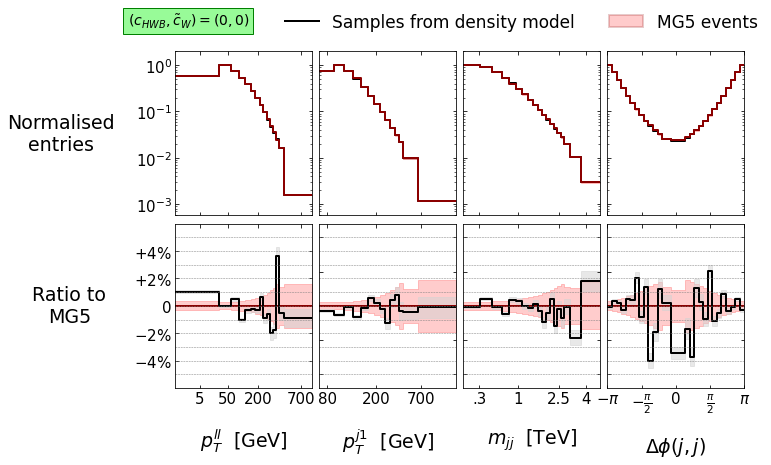

In [21]:
#====================================#
#==  Plot absolute 1D projections  ==#
#====================================#
#
#  Get MG5 data and weights at SM
#
true_data, true_data_weights = data_tables[(0,0)].get_observables_and_weights()
#
#  Plot sampled and MG5 data together
#
plot_1D_projections(fake_datapoints_SM_big, 
                    true_data, 
                    weights_den=true_data_weights, 
                    is_latent=False,
                    savefig=f"figures/Figure9/Fig9.pdf")


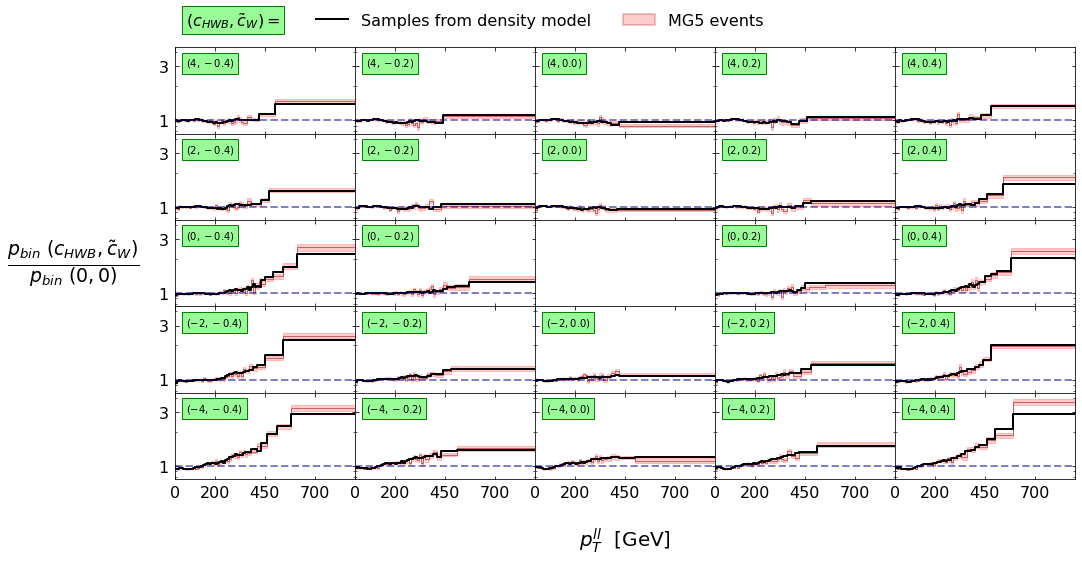

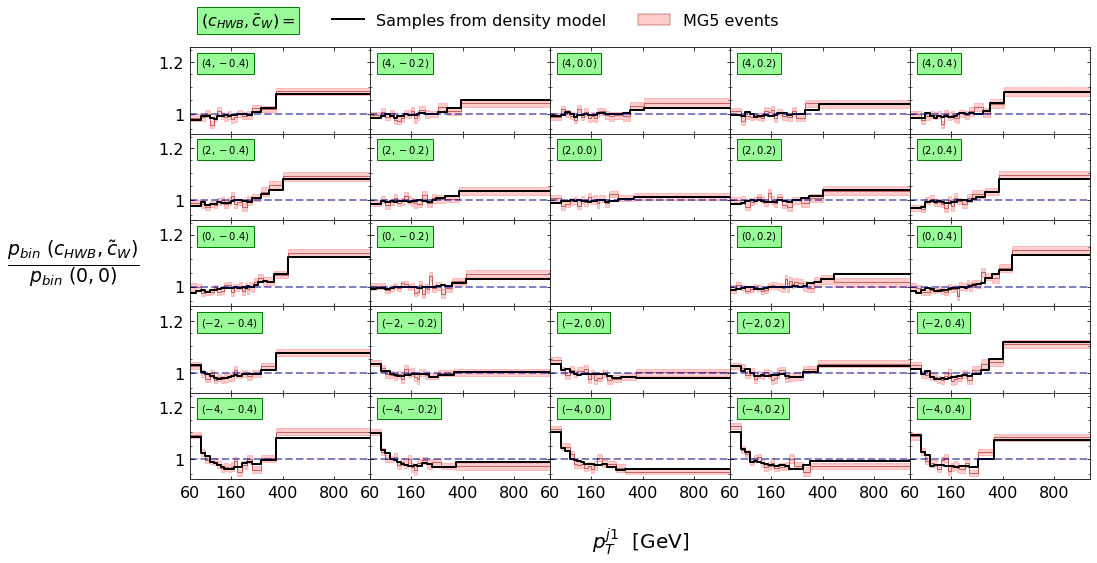

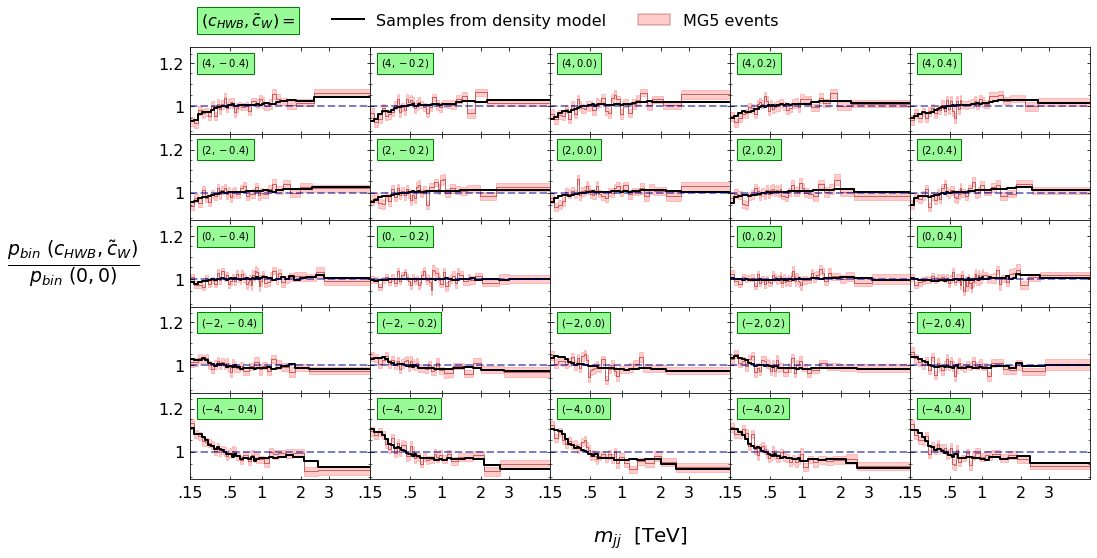

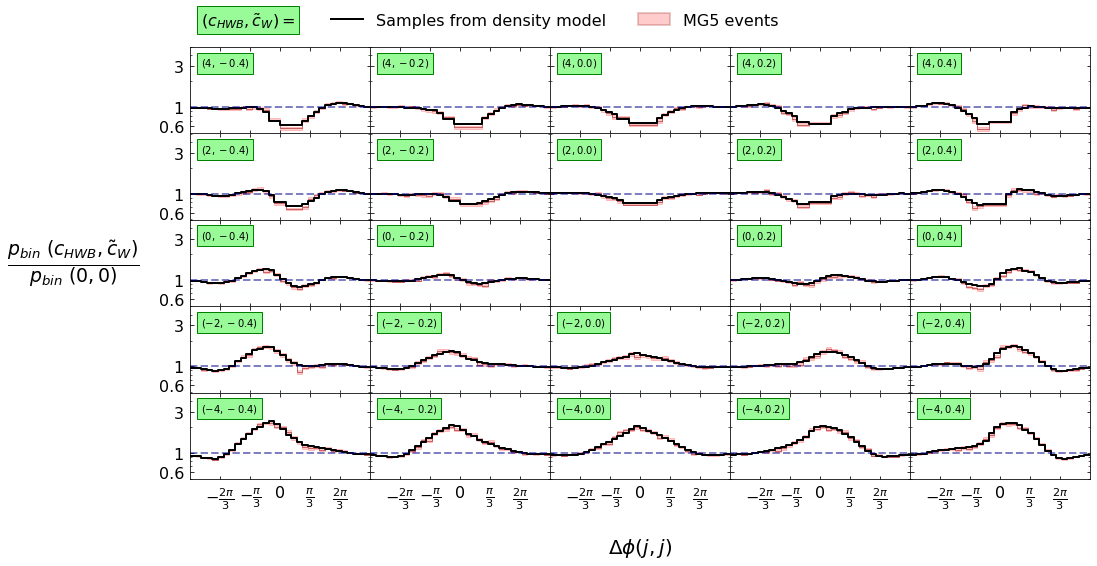

In [22]:
#====================================================#
#==  Plot 1D ratios comparing c and SM hypotheses  ==#
#====================================================#
#
#  Define some ticks
#
ticks = {}
ticks["pT_ll"    ] = [0, 200, 450, 700]
ticks["pT_j1"    ] = [60, 160, 400, 800]
ticks["m_jj"     ] = [150, 500, 1000, 2000, 3000]
ticks["Dphi_j_j" ] = [-2*np.pi/3, -np.pi/3, 0, np.pi/3, 2*np.pi/3]
#
#  ...and tick labels...
#
ticklabels = {}
ticklabels["Dphi_j_j"] = [r"$-\frac{2\pi}{3}$", r"$-\frac{\pi}{3}$", "0", r"$\frac{\pi}{3}$", r"$\frac{2\pi}{3}$"]
ticklabels["m_jj"    ] = [".15", ".5", "1", "2", "3"]
#
#  Reverse the order of cHWB values for plotting
#
cHWB_plot_vals  = cHWB_vals [::-1]
cWtil_plot_vals = cWtil_vals
#
#  Loop over obervables and make a plot for each
#
num_rows, num_cols = len(cHWB_plot_vals), len(cWtil_plot_vals)
height  , width    = 1.2*num_rows, 2.5*num_cols
for obs_idx, obs in enumerate(VBFZ.observables) :
    real_datapoints_SM, real_weights_SM = observable_data[(0, 0)], weights_to_fit[(0,0)]
    n_fake = len(fake_datapoints_SM)
    fig    = plt.figure(figsize=(width, height))
    first_axis, axes, ymin, ymax = None, [], 1, 1
    for row_idx, cHWB in enumerate(cHWB_plot_vals) :
        for col_idx, cWtil in enumerate(cWtil_plot_vals) :
            if (cHWB==0) and (cWtil==0) : continue
            ax   = fig.add_axes([col_idx/num_cols, (num_rows-1-row_idx)/num_rows, 1./num_cols, 1./num_rows])
            if type(first_axis) == type(None) : first_axis = ax
            axes.append(ax)
            data = data_tables [(cHWB, cWtil)]
            observables, weights = data.get_observables_and_weights()
            bins = get_adaptive_bins_v1(observables[:,obs_idx], weights=weights, obs=obs)
            data_x, y1, ey1 = plot_1D_ratio_on_axis(ax, obs, observables       , real_datapoints_SM, weights                                              , real_weights_SM                              , keys=data.keys, bins=bins, normed=True, ebar=True , label="MG5 events"                , linecolor="darkred", fillcolor="red", fillalpha=0.2, linewidth=0.5, offset=0, log=False)
            data_x, y2, ey2 = plot_1D_ratio_on_axis(ax, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[(cHWB, cWtil)].reshape(n_fake), fake_datapoint_weights[(0,0)].reshape(n_fake), keys=data.keys, bins=bins, normed=True, ebar=False, label="Samples from density model", linecolor="black"  ,                                 linewidth=2  , offset=0, log=False)
            ax.set_xlim([bins[0], bins[-1]])
            ymin = np.min([ymin, np.min(y1-ey1), np.min(y2-ey2)])
            ymax = np.max([ymax, np.max(y1+ey1), np.max(y2+ey2)])
            ax.tick_params(which="both", right=True, top=True, labelsize=16, pad=6, direction="in")
            if (row_idx == 2) and (col_idx == 0) :
                ax.set_ylabel(r"$\frac{p_{bin}~(c_{HWB}, {\tilde c}_W)}{p_{bin}~(0,0)}$", fontsize=27, labelpad=85, rotation=0, va="center")
            if (row_idx == num_rows-1) and (col_idx == 2) :
                ax.set_xlabel(VBFZ.get_obs_label(obs), fontsize=20, labelpad=25)
            ax.set_yscale("log")
            if obs == "pT_ll"    :
                ax.yaxis.set_ticks([1, 3])
                ax.yaxis.set_ticklabels(["1", "3"])
            if obs == "pT_j1"    : 
                ax.yaxis.set_ticks([1, 1.2])
                ax.yaxis.set_ticklabels(["1", "1.2"])
            if obs == "m_jj"     : 
                ax.yaxis.set_ticks([1, 1.2])
                ax.yaxis.set_ticklabels(["1", "1.2"])
            if obs == "Dphi_j_j" : 
                ax.yaxis.set_ticks([0.6, 1, 3])
                ax.yaxis.set_ticklabels(["0.6", "1", "3"])
            if col_idx == 0  :
                ax.yaxis.set_ticklabels([], minor=True)
            else :
                ax.yaxis.set_ticklabels([])
                ax.yaxis.set_ticklabels([], minor=True)
            ax.text(0.06, 0.89, f"$({cHWB:.0f},{cWtil:.1f})$", ha="left", va="top", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0), transform=ax.transAxes)
            if obs not in ["Dphi_j_j", "pT_ll"] : ax.set_xscale("function", functions=log_axis_functions)
            if obs in ticks : ax.xaxis.set_ticks(ticks[obs])
            if row_idx != num_rows - 1 : ax.xaxis.set_ticklabels([])
            elif obs in ticklabels : ax.xaxis.set_ticklabels(ticklabels[obs])
            ax.axhline(1, linestyle="--" , c="darkblue", linewidth=2, alpha=0.5)
            ax.grid(True, which="minor", axis="y", c='azure', ls=':', lw=0.5)
    pad_factor = 0.08 if obs=="pT_ll" else 0.45
    padmin, padmax = (1+0.05)*np.log(ymin) - 0.05*np.log(ymax), (1+pad_factor)*np.log(ymax) - pad_factor*np.log(ymin)
    for ax in axes :
        ax.set_ylim(np.exp([padmin, padmax]))
    first_axis.text(0.06, 1.2, r"$(c_{HWB}, {\tilde c}_W) = $", ha="left", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0), transform=first_axis.transAxes, fontsize=16)
    leg_proxy  = [lines.Line2D([], [], color='black' , linestyle='-', lw=2, alpha=1),
                  plt.Rectangle((0,0),1,1,fc="red",ec="darkred",lw=2,ls="-",alpha=0.2)]
    leg_labels = ["Samples from density model", "MG5 events"]
    first_axis.legend(leg_proxy, leg_labels, loc=(0.75, 1.15), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=16)
    savefig = f"figures/Figs_11_to_14/2D_parameter_space_scan_{obs}.pdf"
    make_sure_dir_exists_for_filename(savefig)
    plt.savefig(savefig, bbox_inches="tight")
    plt.show()

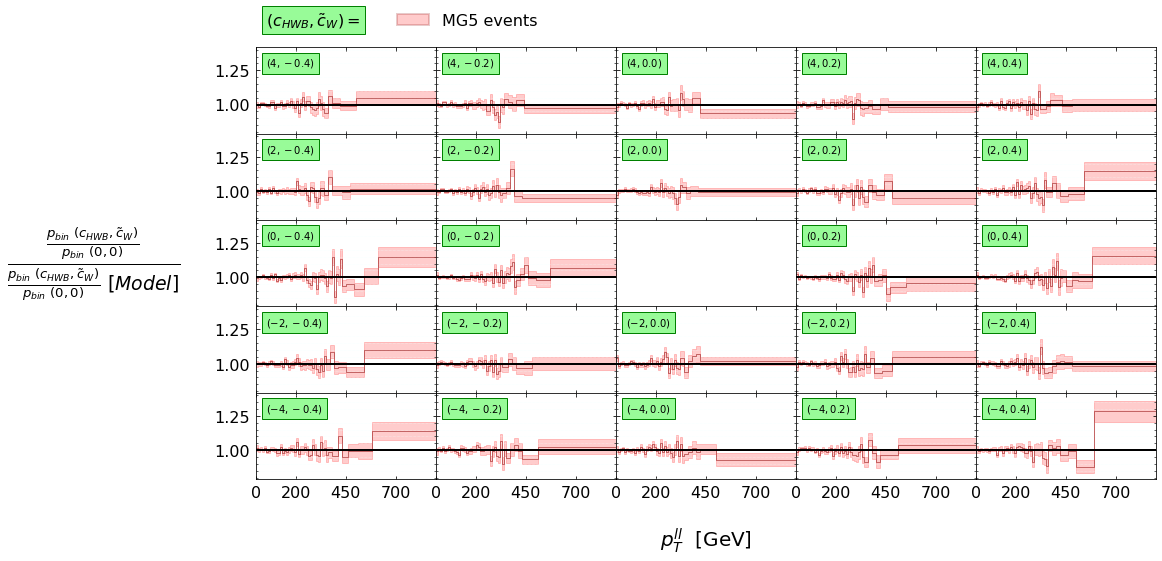

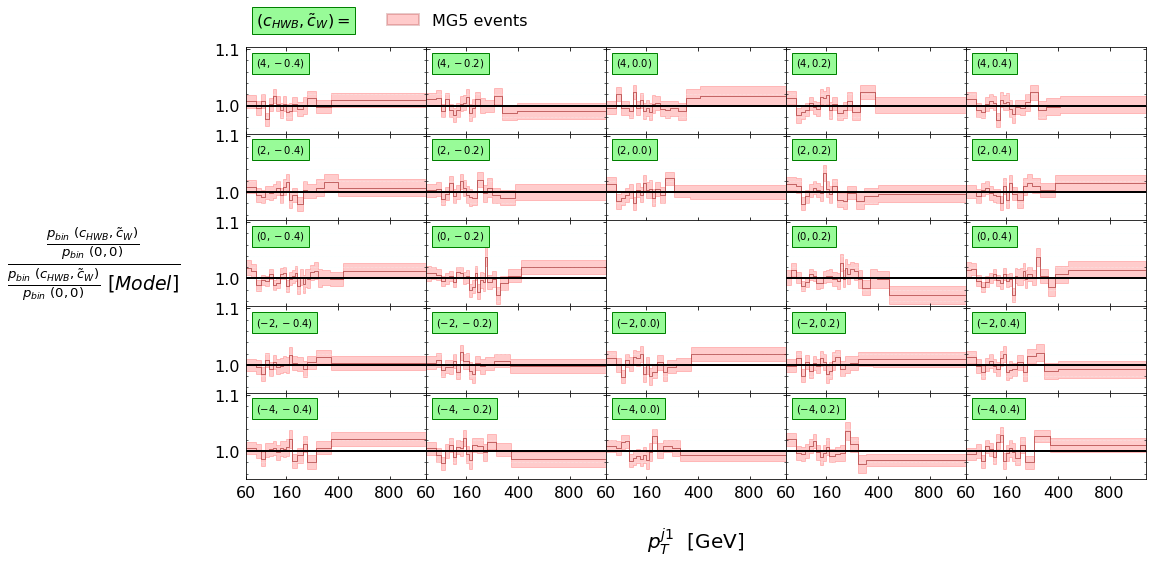

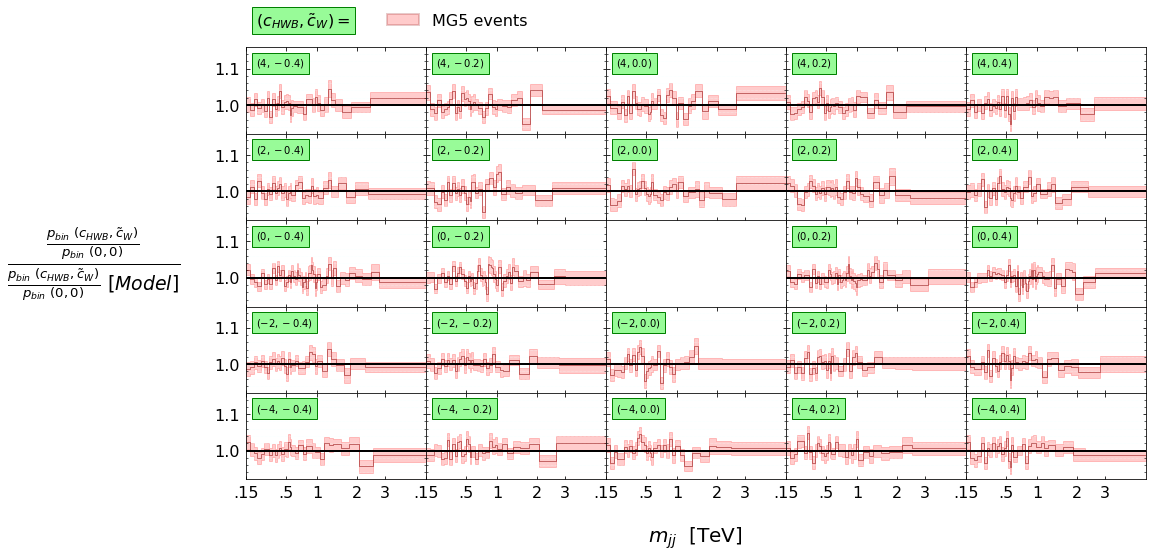

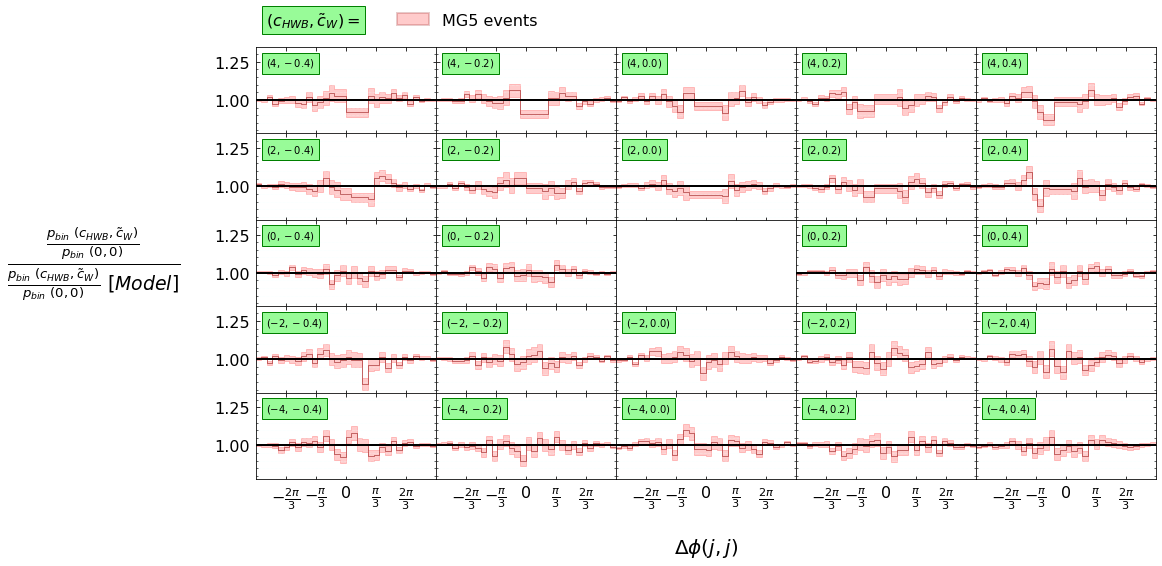

In [23]:
#=================================================================================#
#==  Plot 1D double ratios comparing c and SM hypotheses (MG5 / density model)  ==#
#=================================================================================#
#
#  Loop over obervables and make a plot for each
#
num_rows, num_cols = len(cHWB_plot_vals), len(cWtil_plot_vals)
height  , width    = 1.2*num_rows, 2.5*num_cols
for obs_idx, obs in enumerate(VBFZ.observables) :
    real_datapoints_SM, real_weights_SM = observable_data[(0, 0)], weights_to_fit[(0,0)]
    n_fake = len(fake_datapoints_SM)
    fig    = plt.figure(figsize=(width, height))
    first_axis, axes, ymin, ymax = None, [], 1, 1
    for row_idx, cHWB in enumerate(cHWB_plot_vals) :
        for col_idx, cWtil in enumerate(cWtil_plot_vals) :
            if (cHWB==0) and (cWtil==0) : continue
            ax   = fig.add_axes([col_idx/num_cols, (num_rows-1-row_idx)/num_rows, 1./num_cols, 1./num_rows])
            if type(first_axis) == type(None) : first_axis = ax
            axes.append(ax)
            data = data_tables [(cHWB, cWtil)]
            observables, weights = data.get_observables_and_weights()
            bins = get_adaptive_bins_v1(observables[:,obs_idx], weights=weights, obs=obs)
            data_x, y1, ey1 = plot_1D_double_ratio_on_axis(ax, obs, 
                                                           observables                                          , real_datapoints_SM                           , 
                                                           fake_datapoints_SM                                   , fake_datapoints_SM                           , 
                                                           weights                                              , real_weights_SM                              , 
                                                           fake_datapoint_weights[(cHWB, cWtil)].reshape(n_fake), fake_datapoint_weights[(0,0)].reshape(n_fake), 
                                                           allow_den_errs=False,
                                                           keys=data.keys, bins=bins, normed=True, ebar=True , 
                                                           label="MG5 events", linecolor="darkred", fillcolor="red", fillalpha=0.2, linewidth=0.5, offset=0, log=False)
            ax.set_xlim([bins[0], bins[-1]])
            ymin = np.min([ymin, np.min(y1-ey1)])
            ymax = np.max([ymax, np.max(y1+ey1)])
            ax.tick_params(which="both", right=True, top=True, labelsize=16, pad=6, direction="in")
            if (row_idx == 2) and (col_idx == 0) :
                ax.set_ylabel(r"$\frac{\frac{p_{bin}~(c_{HWB}, {\tilde c}_W)}{p_{bin}~(0,0)}}{\frac{p_{bin}~(c_{HWB}, {\tilde c}_W)}{p_{bin}~(0,0)}~[Model]}$", fontsize=27, labelpad=120, rotation=0, va="center")
            if (row_idx == num_rows-1) and (col_idx == 2) :
                ax.set_xlabel(VBFZ.get_obs_label(obs), fontsize=20, labelpad=25)
            if col_idx == 0  :
                ax.yaxis.set_ticklabels([], minor=True)
            else :
                ax.yaxis.set_ticklabels([])
                ax.yaxis.set_ticklabels([], minor=True)
            ax.text(0.06, 0.89, f"$({cHWB:.0f},{cWtil:.1f})$", ha="left", va="top", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0), transform=ax.transAxes)
            if obs not in ["Dphi_j_j", "pT_ll"] : ax.set_xscale("function", functions=log_axis_functions)
            if obs in ticks : ax.xaxis.set_ticks(ticks[obs])
            if row_idx != num_rows - 1 : ax.xaxis.set_ticklabels([])
            elif obs in ticklabels : ax.xaxis.set_ticklabels(ticklabels[obs])
            ax.axhline(1, linestyle="-" , c="k", linewidth=2)
            ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
            ax.grid(True, which="minor", axis="y", c='azure', ls=':', lw=0.5)
    pad_factor = 0.08 if obs=="pT_ll" else 0.45
    padmin, padmax = (1+0.05)*np.log(ymin) - 0.05*np.log(ymax), (1+pad_factor)*np.log(ymax) - pad_factor*np.log(ymin)
    for ax in axes :
        ax.set_ylim(np.exp([padmin, padmax]))
    first_axis.text(0.06, 1.2, r"$(c_{HWB}, {\tilde c}_W) = $", ha="left", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0), transform=first_axis.transAxes, fontsize=16)
    leg_proxy  = [plt.Rectangle((0,0),1,1,fc="red",ec="darkred",lw=2,ls="-",alpha=0.2)]
    leg_labels = ["MG5 events"]
    first_axis.legend(leg_proxy, leg_labels, loc=(0.75, 1.15), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=16)
    savefig = f"figures/Auxilliary/2D_parameter_space_scan_{obs}_double_ratios.pdf"
    make_sure_dir_exists_for_filename(savefig)
    plt.savefig(savefig, bbox_inches="tight")
    plt.show()

##  6. Make 2D plots

We will now plot the absolute 2D distributions at the SM. 

We will then plot the pull on the ratio comparing the density model events with those from MG5. This demonstrates if there is any systematic mismodelling beyond statistical fluctuations.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


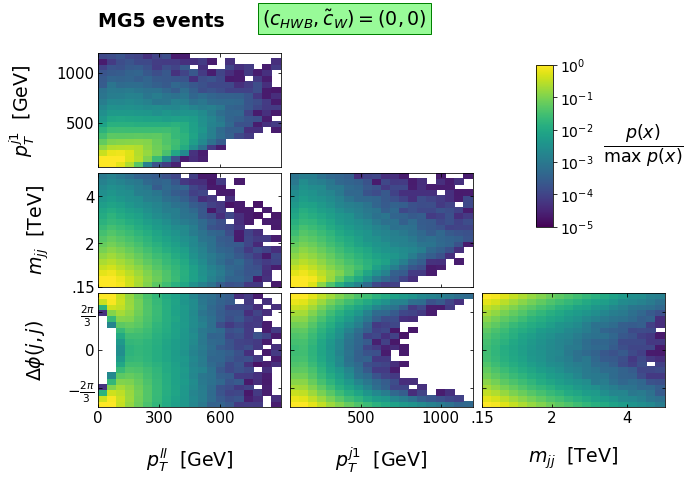

In [24]:
#==================================================#
#==  Plot 2D projections at SM hypothesis (MG5)  ==#
#==================================================#
#
datapoints_true, weights_true = data_tables[(0,0)].get_observables_and_weights()
plot_2D_projections(datapoints_true, 
                    weights_true, 
                    label="MG5 events", 
                    savefig=f"figures/Auxilliary/4obs_2D_marginal_dist_MG5.pdf")


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


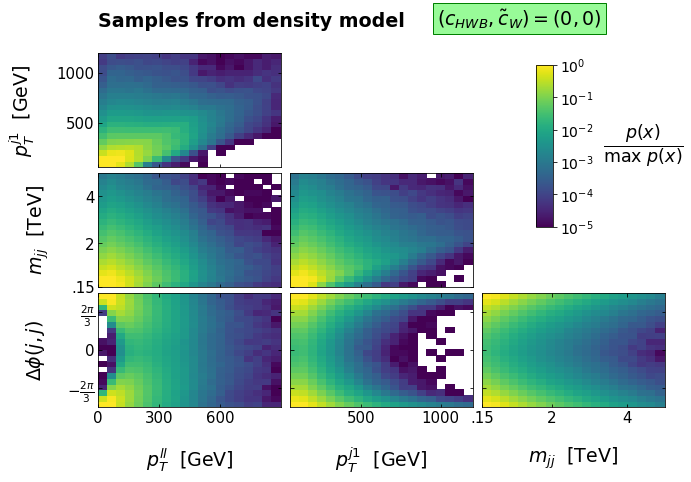

In [25]:
#============================================================#
#==  Plot 2D projections at SM hypothesis (density model)  ==#
#============================================================#
#
plot_2D_projections(fake_datapoints_SM_big, 
                    label="Samples from density model", 
                    savefig=f"figures/Auxilliary/4obs_2D_marginal_dist_model.pdf")


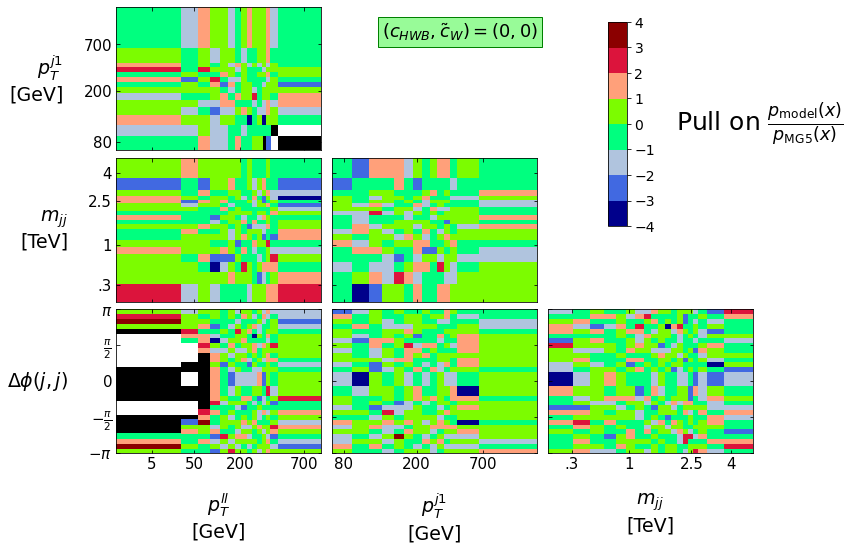

In [26]:
#===============================================#
#==  Compare 2D projections at SM hypothesis  ==#
#===============================================#
#
plot_2D_ratios(fake_datapoints_SM_big, 
               datapoints_true, 
               weights_den=weights_true, 
               is_latent=False, 
               savefig=f"figures/Figure10/Fig10.pdf")
